<h3>NLP Feature Engineering</h3>

I have streamlined the analysis with the NLP pipeline included in `NLP.py`. By creating an `NLModeler`, I can read in unstructured text, apply preprocessing, create a dictionary and a full corpus, and utilize tf-idf and topic modeling. The features calculated from these models will be explored, and combined with those already included in the `articles` and `sentences` tables in the `medium` database, and combined into a useful model.

<b>Goals:</b>
<ol>
<li>Read in `articles` and `sentences` dbs.</li>
<li>Use an NLModeler to create chained tf-idf and lsa models.</li>
<li>Calculate the mean tf-idf per sentence.</li>
<li>Plot the distribution of stfidf by highlight label.</li>
<li>Plot a scatter of stfidf versus other potential features.</li>
<li>Calculate the similarity in LSA space of each sentence to its own article.</li>
</ol>

In [2]:
# import libraries

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import NLP
from matplotlib import pyplot as plt

<h4>1. Read in articles and sentences dbs.</h4>

In [3]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [4]:
# get articles df, drop missing data
dfA = pd.read_sql('articles', dbe, index_col='postid')
dfA = dfA.dropna(axis=0,how='any')
print(dfA.shape)
dfA.head()

(4649, 13)


,title,popdate,url,userid,username,highlight,nlikes,ncomments,ntags,origdb,tags,text,npar
postid,,,,,,,,,,,,,
1015a0f4961d,Day One: President Obama and the First Family ...,2016-03-21,https://medium.com/@ObamaWhiteHouse/day-one-pr...,ca9f8f16893b,The Obama White House,"Today, Air Force One touched down here in Hava...",336,15,3.0,3.0,"Cuba,Twitter,Cuba Trip","¡Hola desde cuba! Today, Air Force One touched...",20.0
101a407e8c61,You don’t ‘make it’ — it makes you.,2016-06-02,https://medium.com/the-mission/you-dont-make-i...,5ce28105ffbc,Jon Westenberg,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0
1030d29376f1,UX: Infinite Scrolling vs. Pagination,2016-05-02,https://uxplanet.org/ux-infinite-scrolling-vs-...,bcab753a4d4e,Nick Babich,There are only a few instances where infinite ...,1.91K,46,4.0,3.0,"UX,Design,User Experience,UX Design",“Should I use Infinite scrolling or Pagination...,34.0
10315016b299,A Lesson on Stereotypes,2016-08-20,https://medium.com/@mramsburg85/a-lesson-on-st...,d38709ba4e06,Michael Ramsburg,"Stereotypes strip you of your culture, like ou...",583,103,5.0,3.0,"Stereotypes,Appalachia,Culture,Essay,Opinion","Stereotypes./nMrs. Mitchell, my sixth grade te...",12.0
10321e751c6d,"For This Republican, Never Trump Means “I’m Wi...",2016-07-30,https://medium.com/@ccmccain/for-this-republic...,4e965facd5f9,Caroline McCain,"Trump’s statement, in my view, is unforgivable...",2.5K,302,5.0,3.0,"Hillary Clinton,Donald Trump,Never Trump,2016 ...","If you know me at all, you know I am a woman f...",45.0


In [5]:
# get sentences df
dfS = pd.read_sql('sentences', dbe, index_col='level_0')
print(dfS.shape)
dfS.head()

(434792, 7)


,alength,index,postid,sentence,slabel,sposition,swcount
level_0,,,,,,,
0,52,0.0,1015a0f4961d,"{hola,desde,cuba}",False,0,3
1,52,0.0,1015a0f4961d,"{today,air,force,one,touched,havana,first,time...",True,1,9
2,52,0.0,1015a0f4961d,"{question,remarkable,moment,relationship,unite...",False,2,9
3,52,0.0,1015a0f4961d,"{also,landmark,progress,made,since,president,o...",False,3,29
4,52,0.0,1015a0f4961d,"{trip,also,professionally,personally,meaningfu...",False,4,19


<h4>2. Use an NLModeler to create chained tf-idf and lsa models.</h4>

In [10]:
mText = NLP.NLModeler(list(dfA.text))
print(mText)

In [11]:
mText.process_text(break_on=['.'], init_split_on='database', origdb=list(dfA.origdb))
dfP = mText.get_text(ttype='tokenized',output_type='dataframe')
print(dfP.shape)
dfP.head()

(4640, 741)


,0,1,2,3,4,5,6,7,8,9,...,731,732,733,734,735,736,737,738,739,740
0,"[hola, desd, cuba]","[today, air, forc, one, touch, havana, first, ...","[question, remark, moment, relationship, unit,...","[also, landmark, progress, made, sinc, presid,...","[trip, also, profession, person, meaning, spec...","[good, illustr, close, two, countri, link, tri...","[look, forward, learn, first, hand, cuban, cul...","[daili, basi, answer, question, presid, trip, ...","[pose, question, twitter, use, askpresssec, an...","[let, start, question, know, mani, american, c...",...,None,None,None,None,None,None,None,None,None,None
1,"[alway, want, make]","[grew, dream, rockstar, paradigm, made, tv, se...","[paradigm, point, life, work, paid, happi]","[everyth, chang, better]","[know, idea, head, around, would, look, like, ...","[sign, record, deal, thought, would, moment, p...","[know, felt, like, happen]",[differ],"[feel, differ, moment, chang, life, big, way]","[year, later, fell, apart, drop, label, chang,...",...,None,None,None,None,None,None,None,None,None,None
2,"[use, infinit, scroll, pagin, content]","[design, still, refere, tug, war, two, method,...","[strength, weak, articl, overview, two, method...","[infinit, scroll, techniqu, allow, user, scrol...","[techniqu, simpli, keep, refresh, page, scroll]","[tempt, may, sound, techniqu, one, size, fit, ...","[use, scroll, prime, method, explor, data, may...","[popular, social, media, massiv, amount, data,...","[infinit, scroll, almost, must, featur, discov...","[user, search, someth, specif, need, see, larg...",...,None,None,None,None,None,None,None,None,None,None
3,[stereotyp],[mr],"[mitchel, sixth, grade, teacher, rural, appala...","[scrawl, term, big, tall, letter, stare, us, s...","[studi, moment, silent, eye, scan, face]","[voic, break, silenc, word, project, mouth, ear]","[stereotyp, say]","[take, tidbit, truth, twist, stori, fictiti, n...","[like, one, us, hillbilli]","[someon, say]",...,None,None,None,None,None,None,None,None,None,None
4,"[know, know, woman, fierc, loyal, friend, famili]","[juli, 18, alreadi, knew, enough, reason, neve...","[follow, line, right, wing, wacko, bird, trump...","[insult, grandfath, attack, qualiti, loyalti, ...","[mock, sacrific, mani, given, anguish, famili,...","[grandfath, respond, grace, forgiv, man, held,...","[nurs, grudg, ever, sinc]","[trump, statement, view, unforgiv, speak, kind...","[take, long, move, beyond, person, week, week,...","[lack, tempera, wisdom, navig, ever, increasin...",...,None,None,None,None,None,None,None,None,None,None


In [12]:
mText.make_dictionary()
mText.load_corpus('alldoc_corpus.mm')
mText.make_ddiv_corpus()
mText.make_tfidf()
mText.make_lsa()
mscorp = mText.ddiv_corpus
mtfidf = mText.tfidf

Now, we test the ability to load a new vector (`"new sentence"`), process it with the `quick_input` option, and represent it native BOW space and in tfidf space.

In [13]:
new_vec = NLP.NLProcessor(['new sentence'],quick_input=True)
#new_vec.process_text(break_on=['.'],init_split_on=None)
#new_vec.flatten_text()
ntext = new_vec.get_text(ttype='flat')
mdict = mText.get_dictionary()
print(ntext[0])
print(mdict.doc2bow(ntext[0]))
print(mtfidf[mdict.doc2bow(ntext[0])])

['new', 'sentenc']
[(35, 1), (3889, 1)]
[(35, 0.15207763654644285), (3889, 0.9883685509274606)]


<b>3. Calculate the mean tf-idf per sentence.</b>

In [14]:
sentence_tfidf = mtfidf[mscorp]
stfidf = []
for sent_rep in sentence_tfidf:
    stfidf.append( np.mean([wr[1] for wr in sent_rep]) )
print(len(stfidf))
print(stfidf[0])

/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kimberly/anaconda3/envs/insight_env/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


434792
0.707063742336


In [16]:
# add stfidf to dfS
dfS['stfidf'] = stfidf
dfS.head()

,alength,index,postid,sentence,slabel,sposition,swcount,stfidf
level_0,,,,,,,,
0,52,0.0,1015a0f4961d,"{hola,desde,cuba}",False,0,3,0.707064
1,52,0.0,1015a0f4961d,"{today,air,force,one,touched,havana,first,time...",True,1,9,0.224525
2,52,0.0,1015a0f4961d,"{question,remarkable,moment,relationship,unite...",False,2,9,0.271712
3,52,0.0,1015a0f4961d,"{also,landmark,progress,made,since,president,o...",False,3,29,0.152328
4,52,0.0,1015a0f4961d,"{trip,also,professionally,personally,meaningfu...",False,4,19,0.208126


<b>4. Plot the distribution of tf-idf by sentence label.</b>

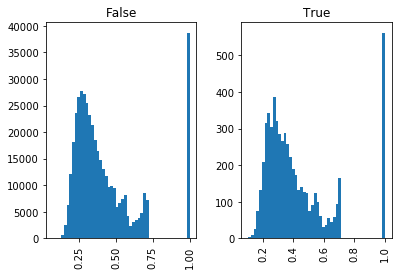

In [17]:
# histogram of tf-idf by label
plt.figure();
dfS['stfidf'].hist(by=dfS.slabel, bins=50)
plt.show()


There is not really any difference here. What about LSA self-article similarity?

<b>5. Calculate the similarity in LSA space of each sentence to its own article.</b>

In [ ]:
# get LSA model and LSA sentence corpus
lsa = mText.lsa

sentence_lsa = lsa[sentence_tfidf]
dfS['sentence_lsa'] = sentence_lsa
print(len(sentence_lsa))
print(len(sentence_lsa[0]))

In [ ]:
lsa.print_topics(5)

In [46]:
# calculate similarity of each sentence to own article

# we set up for similarity queries 
corpus_lsa = mText.get_corpus(ctype='lsa')
from gensim import similarities
sim_index = similarities.Similarity('.',corpus_lsa,num_features = 200)

In [40]:
def sentence_own_sim(sent_reps,index,docpos):
    '''finds similarity of ddivs (ddiv_list is list fo sents with same doc) to own doc'''
    sims = index[list(sent_reps)]
    sims = [s[docpos] for s in sims]
    return sims

In [9]:
# cosine similarity of sentence to title
final_sent_sims = []

test=[dfS.sentence_lsa[dfS.postid==pid] for ax,pid in enumerate(dfA.index) if ax<10]
#dfS.sentence_lsa[dfS.postid==pid]
#final_sent_sims = [sentence_own_sim(df.sentence_lsa[dfS.postid==pid],sim_index,ax)
# for pid in dfA.postid]
    
#final_sent_sims = [s for a in final_sent_sims for s in a]
    
#print(len(final_sent_sims))
#final_sent_sims[0]

AttributeError: 'DataFrame' object has no attribute 'sentence_lsa'